In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
import topojson as tp
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
import io
import base64
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyproj
import geopandas as gpd
import mgwr
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
file_path = 'merged_geo_df.csv'
df = pd.read_csv(file_path)
print(df.head())


   id       code                                           geometry  \
0 NaN  E05000650  POLYGON ((370295 414672, 372394 411758, 370557...   
1 NaN  E05000651  POLYGON ((375017 414993, 375017 414809, 375709...   
2 NaN  E05000652  POLYGON ((373586 410473, 375160 410817, 375327...   
3 NaN  E05000653  POLYGON ((372394 411758, 370295 414672, 373276...   
4 NaN  E05000654  POLYGON ((370557 411414, 372394 411758, 373157...   

          areaName      cx      cy  detached  semiDetached  terraced  \
0    Astley Bridge  370732  412836  0.966641      1.564969  1.334971   
1         Bradshaw  374479  412684  1.370174      1.727901  0.074846   
2       Breightmet  374513  409534 -0.194186      2.489098  1.312189   
3    Bromley Cross  371904  414137  2.609219      0.911970  1.104304   
4  Crompton Bolton  371830  410799 -0.455505      0.602654  3.717106   

      flats  ...       oil      wood     solid  renewable  communal  \
0 -0.145641  ... -0.442458 -0.202465 -0.199341  -0.625874 -0.061271  

In [3]:
from pyproj import Transformer

def bng_to_latlng_vectorized(easting, northing):
    # Create a transformer object for BNG (EPSG:27700) to WGS84 (EPSG:4326)
    transformer = Transformer.from_crs('epsg:27700', 'epsg:4326', always_xy=True)
    # Transform the coordinates
    lon, lat = transformer.transform(easting, northing)
    return lat, lon

# Convert coordinates for the entire DataFrame
df['latitude'], df['longitude'] = bng_to_latlng_vectorized(df['cx'], df['cy'])

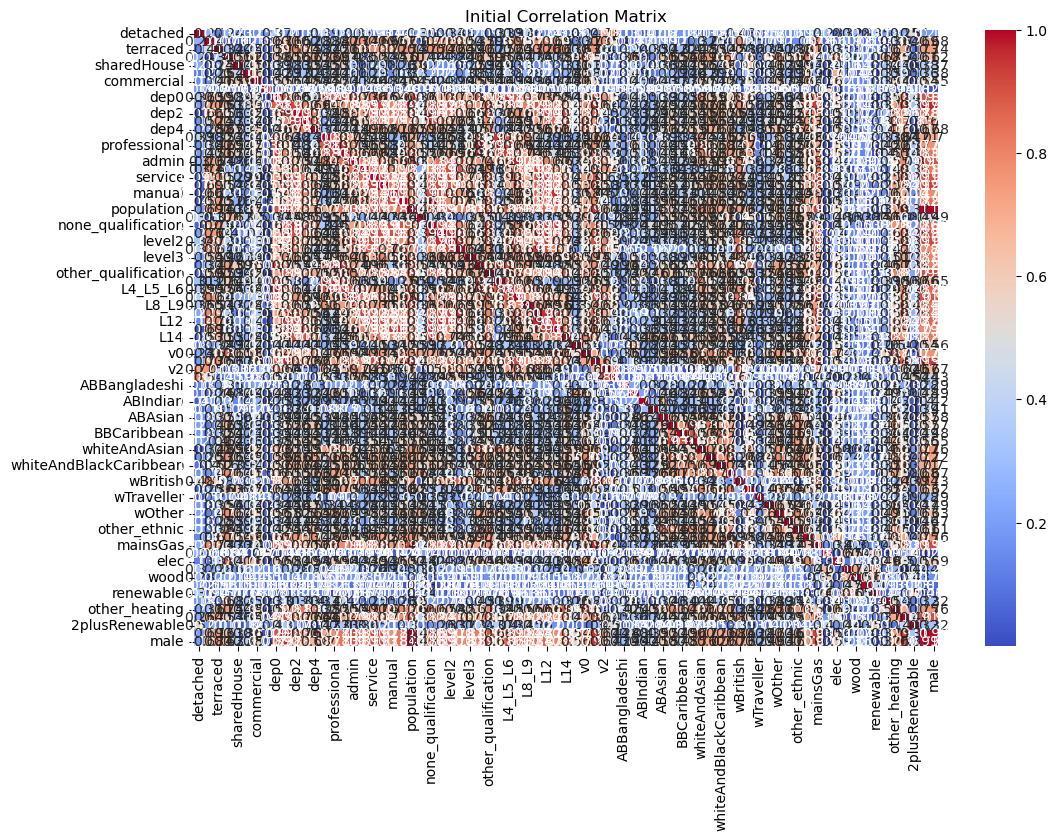

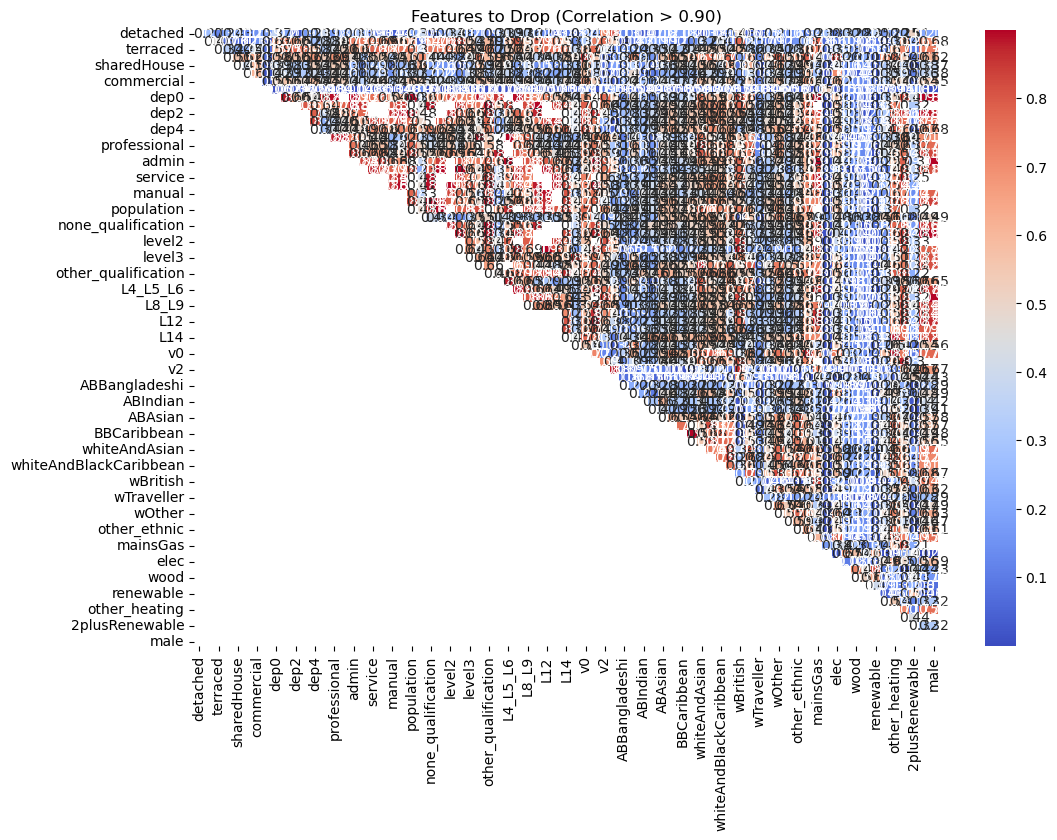

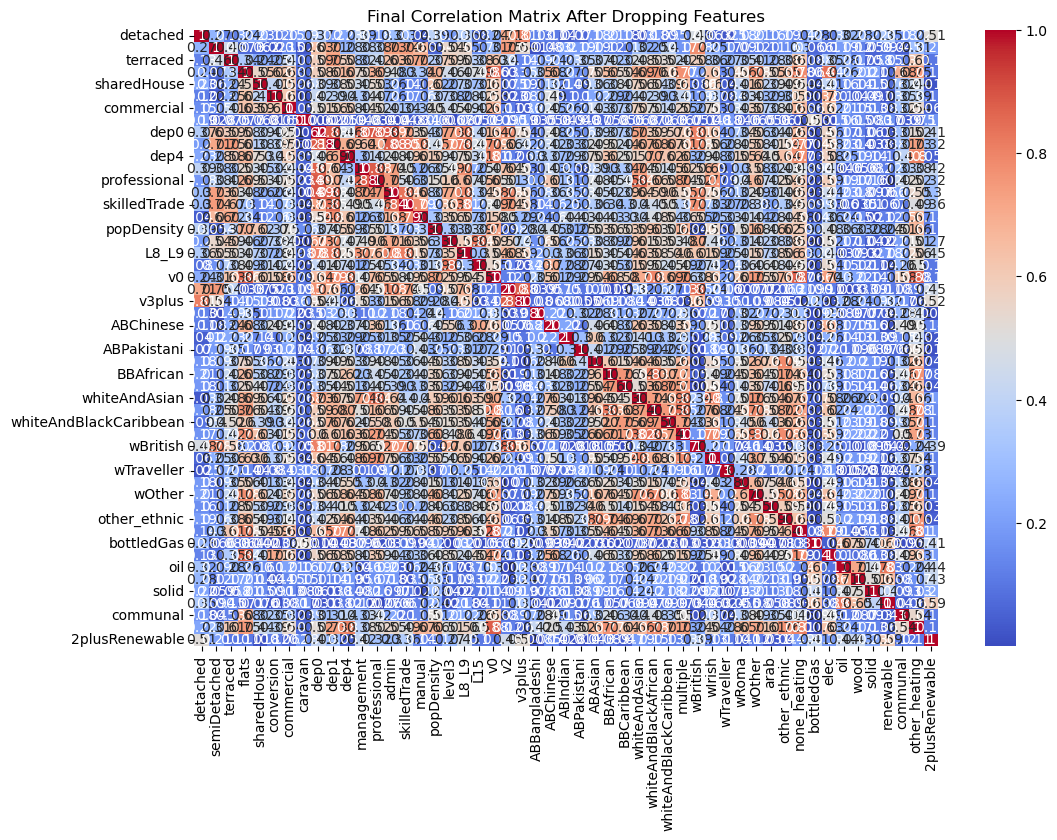

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your main dataframe is df
target_df = df[['vGood']]
columns_to_exclude = ['vGood', 'good', 'fair', 'bad', 'vBad', 'id', 'code', 'geometry', 'areaName', 'cx', 'cy', 'latitude', 'longitude']

# First, filter out the columns you want to exclude
features_df = df.drop(columns=columns_to_exclude)

# Calculate the correlation matrix
corr_matrix = features_df.corr().abs()

# Plot initial correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Initial Correlation Matrix")
plt.show()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Create a mask for highlighting features to drop
mask = upper.applymap(lambda x: x > 0.90)

# Plot the upper triangle of the correlation matrix with highlighted features to drop
plt.figure(figsize=(12, 8))
sns.heatmap(upper, cmap='coolwarm', annot=True, mask=mask)
plt.title("Features to Drop (Correlation > 0.90)")
plt.show()

# Drop features 
features_df.drop(columns=to_drop, inplace=True)

# Recalculate the correlation matrix
new_corr_matrix = features_df.corr().abs()

# Plot final correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(new_corr_matrix, annot=True, cmap='coolwarm')
plt.title("Final Correlation Matrix After Dropping Features")
plt.show()


In [5]:
from sklearn.linear_model import LassoCV

X = (features_df)

# Target variable
y = target_df.values.ravel()

# Increase the range of alphas and the number of iterations
lasso = LassoCV(cv=5, random_state=0, max_iter=10000, alphas=10**np.linspace(-4, -0.5, 100)).fit(X, y)
# Get the feature names
feature_names = features_df.columns

# Extract the coefficients and set a threshold to select features
lasso_coef = lasso.coef_
selected_features = feature_names[lasso_coef != 0]

print("Selected features:", selected_features)


Selected features: Index(['detached', 'semiDetached', 'flats', 'sharedHouse', 'conversion',
       'commercial', 'caravan', 'dep0', 'dep1', 'management', 'professional',
       'admin', 'popDensity', 'level3', 'L8_L9', 'L15', 'v0', 'v2', 'v3plus',
       'ABBangladeshi', 'ABChinese', 'ABIndian', 'ABPakistani', 'ABAsian',
       'BBAfrican', 'BBCaribbean', 'whiteAndAsian', 'whiteAndBlackAfrican',
       'multiple', 'wBritish', 'wIrish', 'wRoma', 'wOther', 'other_ethnic',
       'none_heating', 'bottledGas', 'elec', 'oil', 'wood', 'solid',
       'communal', 'other_heating', '2plusRenewable'],
      dtype='object')


In [6]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Filter the features DataFrame to only include selected features from LASSO
X_selected = features_df[selected_features]

# Train a Random Forest Regressor on the selected features
forest = RandomForestRegressor(random_state=42)
forest.fit(X_selected, y)

# Get feature importances from the Random Forest model
importances = forest.feature_importances_

# Sort the feature importances
indices = np.argsort(importances)[::-1]

# Define the number of top features to print
top_n_features = 10 # Set this to the number of features you want to include

# Print the top feature importances
print(f"Top {top_n_features} features based on Random Forest after pruning:")
for f in range(top_n_features):
    # Check if the number of features is less than top_n_features
    if f < len(indices):
        print(f"{f + 1}. Feature '{X_selected.columns[indices[f]]}' (Importance: {importances[indices[f]]})")
    else:
        break


Top 10 features based on Random Forest after pruning:
1. Feature 'professional' (Importance: 0.23601043922388137)
2. Feature 'management' (Importance: 0.22146719602578438)
3. Feature 'v0' (Importance: 0.11783174590431054)
4. Feature 'dep1' (Importance: 0.10012572041877035)
5. Feature 'wBritish' (Importance: 0.05845941043369048)
6. Feature 'semiDetached' (Importance: 0.03430861939738082)
7. Feature 'level3' (Importance: 0.0250580045747111)
8. Feature 'whiteAndAsian' (Importance: 0.021364857438531986)
9. Feature 'L8_L9' (Importance: 0.021052358365104922)
10. Feature 'L15' (Importance: 0.014187575396499568)


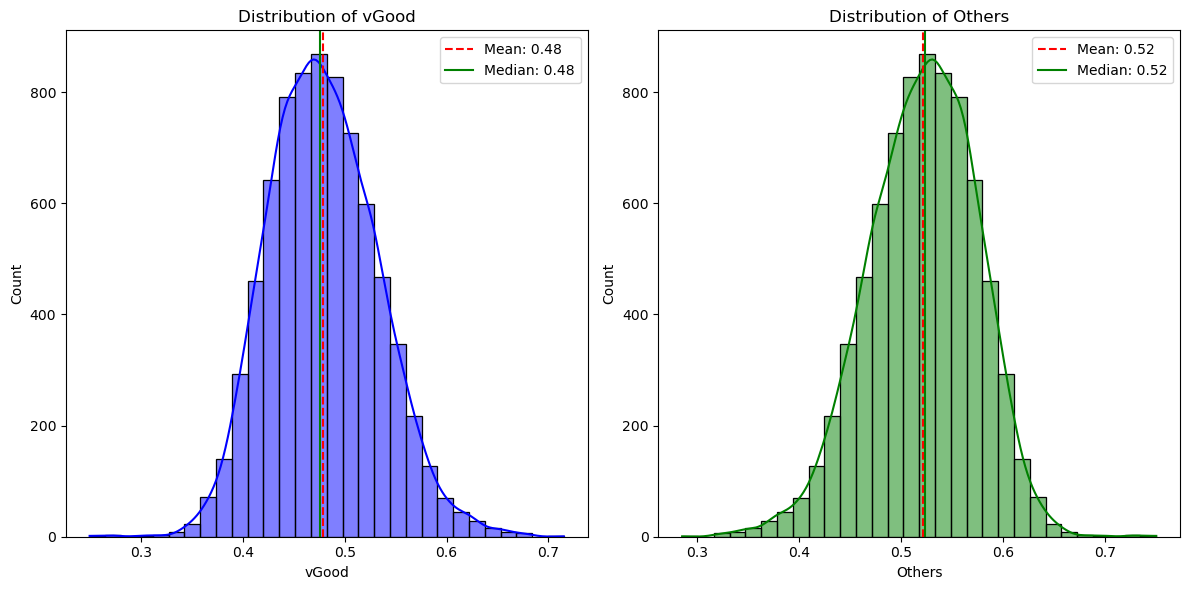

In [7]:

# Keeping 'vGood' as is and summing the rest
df['vGood'] = df['vGood']
df['Others'] = df[['good', 'fair', 'bad', 'vBad']].sum(axis=1)

# Calculate mean and median
vGood_mean = df['vGood'].mean()
vGood_median = df['vGood'].median()
Others_mean = df['Others'].mean()
Others_median = df['Others'].median()

# Visualize the distributions
plt.figure(figsize=(12, 6))

# vGood distribution
plt.subplot(1, 2, 1)
sns.histplot(df['vGood'], kde=True, color='blue', bins=30)
plt.title('Distribution of vGood')
plt.axvline(vGood_mean, color='red', linestyle='--', label=f'Mean: {vGood_mean:.2f}')
plt.axvline(vGood_median, color='green', linestyle='-', label=f'Median: {vGood_median:.2f}')
plt.legend()

# Others distribution
plt.subplot(1, 2, 2)
sns.histplot(df['Others'], kde=True, color='green', bins=30)
plt.title('Distribution of Others')
plt.axvline(Others_mean, color='red', linestyle='--', label=f'Mean: {Others_mean:.2f}')
plt.axvline(Others_median, color='green', linestyle='-', label=f'Median: {Others_median:.2f}')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
import numpy as np

# Calculate the total counts and proportion of 'vGood'
df['total'] = df['vGood'] + df['Others']
df['vGood_prop'] = df['vGood'] / df['total']

# Define a range of possible thresholds
thresholds = np.linspace(0.48, 0.51429, 100)

# Evaluate class distribution for each threshold
best_difference = 0
best_threshold = 0
for threshold in thresholds:
    above_threshold = df['vGood_prop'] > threshold
    below_threshold = ~above_threshold
    num_above = above_threshold.sum()
    num_below = below_threshold.sum()

    # Maximizing the difference between the two classes
    difference = abs(num_above - num_below)
    if difference > best_difference:
        best_difference = difference
        best_threshold = threshold

print(f'Best Threshold: {best_threshold} with Class Difference: {best_difference}')


Best Threshold: 0.51429 with Class Difference: 3819


In [9]:
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
import time

# Create the binary target variable based on the threshold
df['target'] = df['vGood_prop'] > best_threshold

selected_features = ['professional', 'management', 'v0', 'dep1', 'wBritish', 'semiDetached',
                    'level3','whiteAndAsian','L8_L9','L15']

# Features and target variable
X = df[selected_features]  # Use only the selected features
y = df['target']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Define the objective function for Optuna to optimize
def objective(trial):
    # Define hyperparameters to search over
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Create the Random Forest classifier with the suggested hyperparameters
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    # Perform 5-fold cross-validation and calculate the F1 score as the optimization metric
    f1_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='f1')
    f1 = f1_scores.mean()

    return f1
# Start the timer
start_time = time.time()

# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)  # You can adjust the number of trials

# Stop the timer
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print(f"Total duration for Optuna optimization: {duration} seconds")

# Get the best hyperparameters
best_params = study.best_params

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Create the Random Forest classifier with the best hyperparameters
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

# Fit the model to the training data
best_rf_model.fit(X_train, y_train)

# Predict on the validation set using the best model
y_pred_valid = best_rf_model.predict(X_valid)

# Calculate accuracy, F1 score, and ROC AUC on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
f1_valid = f1_score(y_valid, y_pred_valid)
roc_auc_valid = roc_auc_score(y_valid, y_pred_valid)

# Print classification report, accuracy, F1 score, and ROC AUC for validation set
print("\nRandom Forest Validation Metrics:")
print(classification_report(y_valid, y_pred_valid))
print("Accuracy (Validation):", accuracy_valid)
print(f"F1 Score (Validation): {f1_valid:.4f}")
print(f"ROC AUC (Validation): {roc_auc_valid:.4f}")

# Predict on the test set using the best model
y_pred_test = best_rf_model.predict(X_test)

# Calculate metrics on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

# Print test set metrics and classification report
print("\nRandom Forest Test Set Metrics:")
print(classification_report(y_test, y_pred_test))
print("Accuracy (Test):", accuracy_test)
print(f"F1 Score (Test): {f1_test:.4f}")
print(f"ROC AUC (Test): {roc_auc_test:.4f}")


[I 2023-12-06 08:00:02,013] A new study created in memory with name: no-name-ff7a7074-f303-4ecd-9521-a66107780a7f
[I 2023-12-06 08:00:20,602] Trial 0 finished with value: 0.7949140669653384 and parameters: {'n_estimators': 254, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.7949140669653384.


Total duration for Optuna optimization: 18.58979845046997 seconds
Best Hyperparameters:
{'n_estimators': 254, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False}

Random Forest Validation Metrics:
              precision    recall  f1-score   support

       False       0.93      0.96      0.94       564
        True       0.86      0.80      0.83       199

    accuracy                           0.92       763
   macro avg       0.90      0.88      0.89       763
weighted avg       0.91      0.92      0.92       763

Accuracy (Validation): 0.9161205766710354
F1 Score (Validation): 0.8333
ROC AUC (Validation): 0.8798

Random Forest Test Set Metrics:
              precision    recall  f1-score   support

       False       0.93      0.94      0.93       591
        True       0.77      0.75      0.76       172

    accuracy                           0.89       763
   macro avg       0.85      0.84      0.85       763
weighted avg       0.89      0.89     

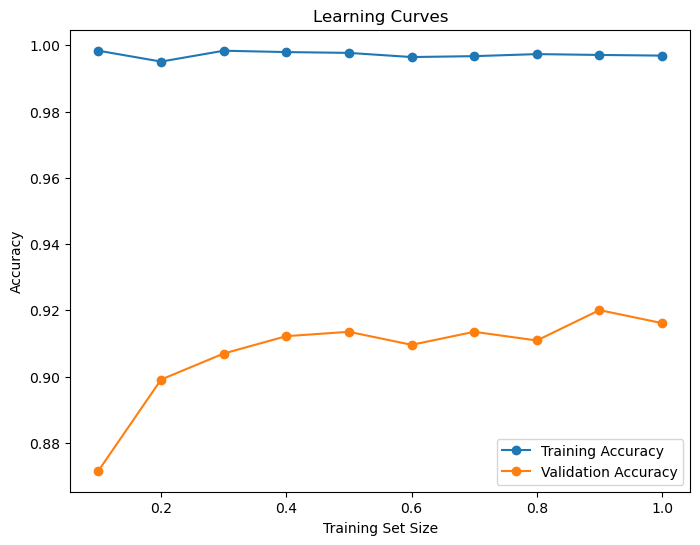

In [10]:
train_sizes = np.linspace(0.1, 1.0, 10)  # Vary the training set size from 10% to 100%
train_scores = []
valid_scores = []

for train_size in train_sizes:
    # Define the subset of the training data
    subset_size = int(train_size * len(X_train))
    X_subset = X_train[:subset_size]
    y_subset = y_train[:subset_size]
    # Fit the model to the subset
    best_rf_model.fit(X_subset, y_subset)

    # Predict on the training and validation sets
    y_pred_train = best_rf_model.predict(X_subset)
    y_pred_valid = best_rf_model.predict(X_valid)

    # Calculate accuracy on the subset and validation set
    train_accuracy = accuracy_score(y_subset, y_pred_train)
    valid_accuracy = accuracy_score(y_valid, y_pred_valid)

    train_scores.append(train_accuracy)
    valid_scores.append(valid_accuracy)

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores, label='Training Accuracy', marker='o')
plt.plot(train_sizes, valid_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [11]:
# Features for geographical locations (you need to define this based on your data)
X_locations = df[selected_features]

# Use the trained Random Forest classifier (best_rf_model) to predict probabilities for each location
predicted_probabilities = best_rf_model.predict_proba(X_locations)

# Extract the probability of the positive class (class 1) for each location
location_probabilities = predicted_probabilities[:, 1]

# Add the location probabilities to your df DataFrame with 'areaName' as the identifier
df['location_probabilities'] = location_probabilities

# Print the DataFrame with location probabilities
print(df[['areaName', 'location_probabilities']])


                    areaName  location_probabilities
0              Astley Bridge                0.001312
1                   Bradshaw                0.000000
2                 Breightmet                0.000000
3              Bromley Cross                0.881234
4            Crompton Bolton                0.018963
...                      ...                     ...
7624               St Arvans                0.136024
7625            St Kingsmark                0.871391
7626      Town Monmouthshire                0.000984
7627  West End Monmouthshire                0.051837
7628                 Wyesham                0.003346

[7629 rows x 2 columns]


In [12]:
from shapely import wkt
df['geometry'] = df['geometry'].apply(wkt.loads) #uncomment this line if error occurs
# Convert df to GeoDataFrame if necessary
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [13]:
print(gdf)

      id       code                                           geometry  \
0    NaN  E05000650  POLYGON ((370295.000 414672.000, 372394.000 41...   
1    NaN  E05000651  POLYGON ((375017.000 414993.000, 375017.000 41...   
2    NaN  E05000652  POLYGON ((373586.000 410473.000, 375160.000 41...   
3    NaN  E05000653  POLYGON ((372394.000 411758.000, 370295.000 41...   
4    NaN  E05000654  POLYGON ((370557.000 411414.000, 372394.000 41...   
...   ..        ...                                                ...   
7624 NaN  W05001796  POLYGON ((353864.000 205106.000, 352671.000 20...   
7625 NaN  W05001797  POLYGON ((353220.000 194117.000, 353029.000 19...   
7626 NaN  W05001798  POLYGON ((349857.000 212516.000, 350763.000 21...   
7627 NaN  W05001799  POLYGON ((347019.000 188542.000, 347043.000 18...   
7628 NaN  W05001800  POLYGON ((352767.000 215154.000, 355271.000 21...   

                    areaName      cx      cy  detached  semiDetached  \
0              Astley Bridge  370732  4

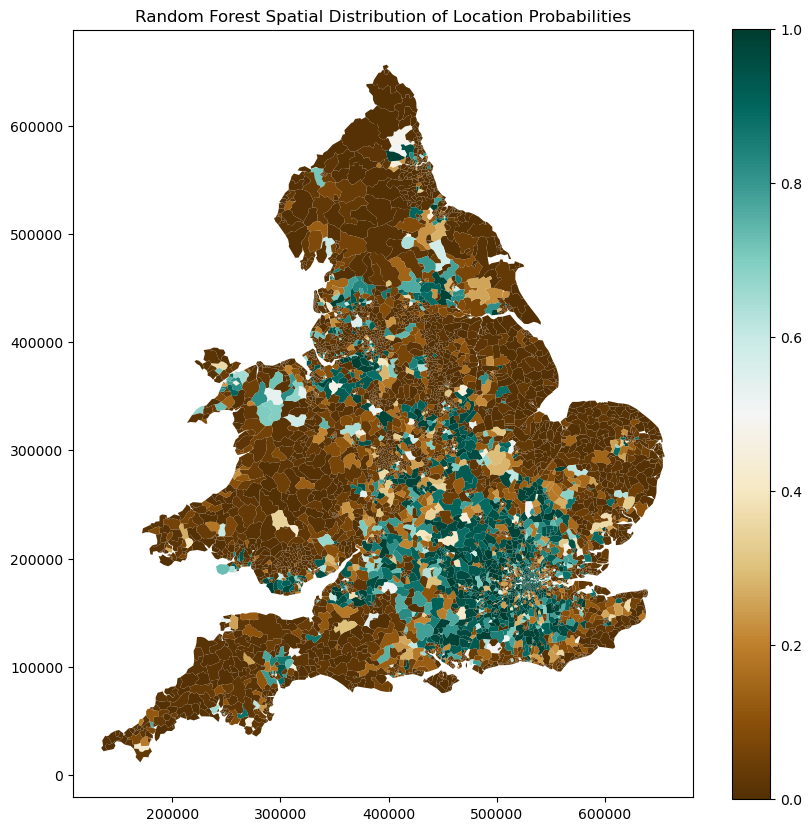

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get the BrBG color scheme from Plotly
brbg_palette = px.colors.diverging.BrBG

# Convert 'rgb()' format to hexadecimal
def rgb_to_hex(rgb_str):
    rgb = rgb_str.strip('rgb()').split(',')
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

brbg_hex_palette = [rgb_to_hex(color) for color in brbg_palette]

# Create a colormap using the converted hexadecimal colors
brbg_cmap = mcolors.LinearSegmentedColormap.from_list("BrBG", brbg_hex_palette)

# Assuming gdf is your GeoDataFrame with geometry and location_probabilities column

# Plotting Location Probabilities using the RdYlGn colormap
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='location_probabilities', cmap=brbg_cmap, legend=True, ax=ax)
ax.set_title('Random Forest Spatial Distribution of Location Probabilities')
plt.show()


In [15]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px

# Initialize the Dash app
app = dash.Dash(__name__)

# Updated Metrics for visualization including location_probabilities
metrics = {
    'Location Probabilities': 'location_probabilities'  
}

# Layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='metric-dropdown',
        options=[{'label': k, 'value': v} for k, v in metrics.items()],
        value='location_probabilities'  # Default metric
    ),
    dcc.Graph(id='map', style={'height': '85vh', 'width': '100%'})
])

# Callback to update the map
@app.callback(
    Output('map', 'figure'),
    Input('metric-dropdown', 'value')
)
def update_map(selected_metric):
    fig = px.scatter_mapbox(
        gdf,
        lat="latitude",
        lon="longitude",
        hover_name='areaName',
        color=selected_metric,
        color_continuous_scale=px.colors.diverging.BrBG,
        size_max=20,
        zoom=5,
        mapbox_style="carto-darkmatter"
    )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, autosize=True)
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.